(joint-grav-mag-code)= 

# Joint Cross-Gradient Inversion of Gravity and Magnetic Data

In this example, we demonstrate the **joint inversion** of gravity and magnetic datasets from the Forrestania Greenstone Belt using a **cross-gradient structural constraint** to encourage structural similarity.

For a streamlined version of this workflow, see the parent case study:  
👉 [Forrestania Case Study](https://mirageoscience-simpeg-drivers.readthedocs-hosted.com/en/geopy-2297/case_studies/Forrestania/forrestania.html#forrestania)

**In this tutorial, we will:**
- Define gravity and magnetic surveys from `xyz`-formatted datasets.
- Build an adaptive octree mesh using survey geometry and topography.
- Use topography to define active cells for inversion.
- Formulate a **joint inversion** with:
  - A single data misfit term (sum of gravity and magnetics misfits).
  - A single regularization term combining:
    - Weighted gravity and magnetics regularizations.
    - A weighted cross-gradient coupling term to enforce structural similarity.
    - Weights controlling the relative influence of each term in the total regularization.
  - A shared trade-off parameter (β) balancing misfit and regularization.
  - An optimization strategy for model updates.
- Specify inversion directives to guide the process.
- Visualize the recovered models and the data misfit.

While this tutorial focuses on gravity and magnetic anomaly data, the approach can be extended to **gradiometry data**, **electromagnetics**, and other types of geophysical data.

> 💡 **Note**:  
> This workflow closely follows the methodology and structure of the official [SimPEG Tutorials](https://simpeg.xyz/user-tutorials/).

```{figure} ../images/open_code.png
```

In [1]:
# Import necessary Python libraries for data handling and visualization
import os
import zipfile
from pathlib import Path
from tempfile import mkdtemp

# Import CET colormaps
import colorcet as cc
import discretize
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas
import scipy as sp
import simpeg
from geoh5py import Workspace, objects
from matplotlib import gridspec
from matplotlib.colors import TwoSlopeNorm
from PIL import Image
from scipy.interpolate import griddata

# Import SimPEG library
from simpeg import (
    dask,  # Parallel version of the code
    maps,
    potential_fields,
)
from simpeg.maps import InjectActiveCells
from simpeg.utils import plot2Ddata

# Mira Geoscience specific libraries
from simpeg_drivers import assets_path

## Geological Setting

See the [Forrestania - Geology](forrestania-geology) section for more details.

## Data Preparation

For this joint inversion example, we load preprocessed data directly from NumPy arrays included in the [simpeg-drivers repository](https://github.com/MiraGeoscience/simpeg-drivers).

Readers are invited to read the preprocessing steps performed in the unconstrained gravity and magnetic notebooks that culminated in these arrays.

- [Unconstrained Gravity Inversion notebook](gravity-code)  
- [Unconstrained Magnetic Inversion notebook](magnetics-code)

The zipped dataset includes the following files:

-  **Ground gravity survey**  📍  
  `Forrestania_Gravity_Station_trim_.csv` 
    
-  **Airborne magnetic survey**  ✈️  
      `60472_AOI4.csv`
-  **Digital Elevation Model (DEM)**  🗺️  
    `Forrestania_SRTM1 Australia_MGA50.tiff`
      

In [2]:
# Load preprocessed datasets from local assets in simpeg-drivers
grav_array = np.load(assets_path() / "Case studies" / "gravity.npy")
print(f"Loaded gravity data: {grav_array.shape}")

mag_array = np.load(assets_path() / "Case studies" / "magnetic.npy")
print(f"Loaded magnetic data: {mag_array.shape}")

dem = np.load(assets_path() / "Case studies" / "dem.npy")
print(f"Loaded DEM data: {dem.shape}")

Loaded gravity data: (992, 4)
Loaded magnetic data: (2500, 4)
Loaded DEM data: (738446, 3)


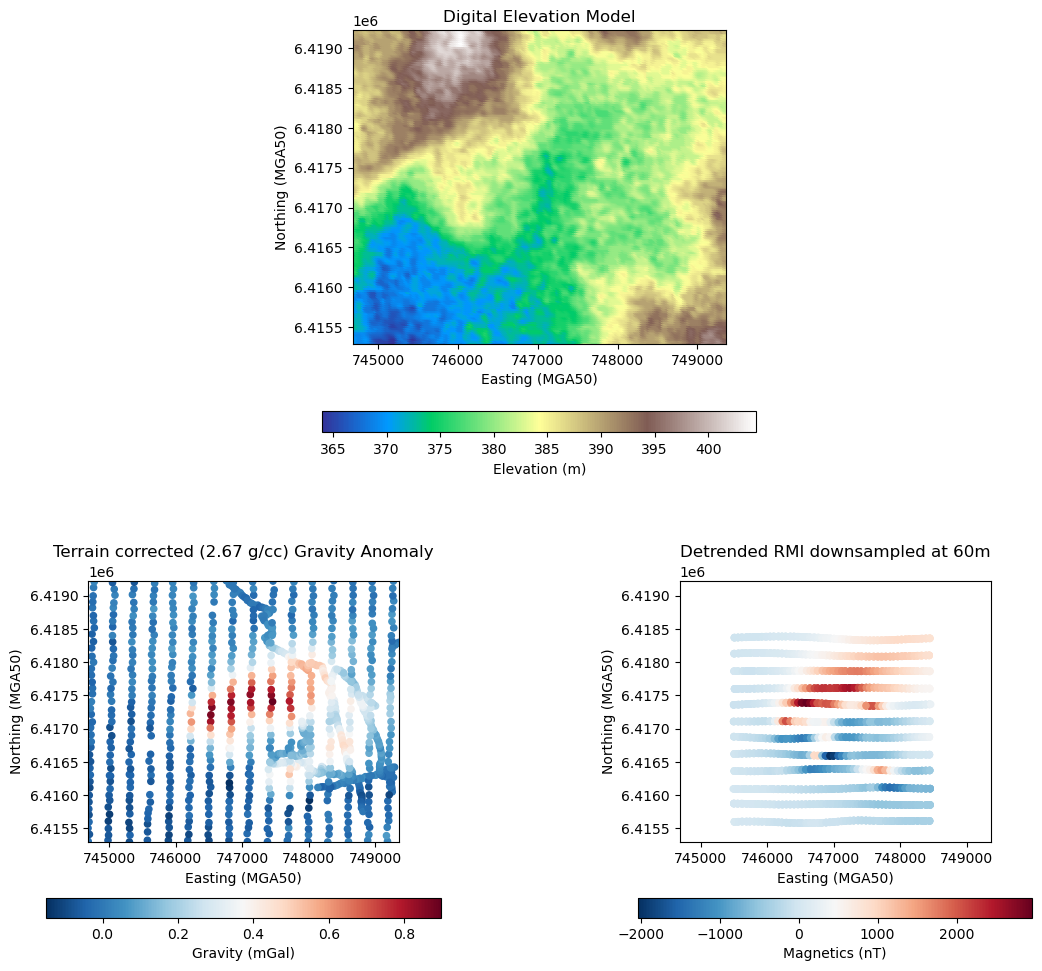

In [3]:
# Plot DEM, gravity and magnetic data

# Define common extents for all plots from gravity data
extent_x = [grav_array[:, 0].min(), grav_array[:, 0].max()]
extent_y = [grav_array[:, 1].min(), grav_array[:, 1].max()]

# Mask DEM within extent and compute local elevation range for better colormap scaling
dem_mask = (
    (dem[:, 0] >= extent_x[0])
    & (dem[:, 0] <= extent_x[1])
    & (dem[:, 1] >= extent_y[0])
    & (dem[:, 1] <= extent_y[1])
)
dem_local = dem[dem_mask]
vmin, vmax = dem_local[:, 2].min(), dem_local[:, 2].max()

# Set up custom GridSpec layout for enabling centralized DEM
fig = plt.figure(figsize=(14, 12))
gs = gridspec.GridSpec(2, 2, height_ratios=[1.2, 1], hspace=0.25)

# DEM (top, centered)
ax_dem = fig.add_subplot(gs[0, :])
sc1 = ax_dem.scatter(
    dem_local[:, 0],
    dem_local[:, 1],
    c=dem_local[:, 2],
    cmap="terrain",
    s=20,
    vmin=vmin,
    vmax=vmax,
)
ax_dem.set(
    title="Digital Elevation Model",
    xlabel="Easting (MGA50)",
    ylabel="Northing (MGA50)",
    xlim=extent_x,
    ylim=extent_y,
    aspect="equal",
)
cb1 = fig.colorbar(sc1, ax=ax_dem, orientation="horizontal", shrink=0.4)
cb1.set_label("Elevation (m)")

# Gravity anomaly (bottom-left)
ax_grav = fig.add_subplot(gs[1, 0])
sc2 = ax_grav.scatter(
    grav_array[:, 0], grav_array[:, 1], c=grav_array[:, 3], cmap="RdBu_r", s=20
)
ax_grav.set(
    title="Terrain corrected (2.67 g/cc) Gravity Anomaly",
    xlabel="Easting (MGA50)",
    ylabel="Northing (MGA50)",
    xlim=extent_x,
    ylim=extent_y,
    aspect="equal",
)
cb2 = fig.colorbar(sc2, ax=ax_grav, orientation="horizontal", shrink=0.8)
cb2.set_label("Gravity (mGal)")

# Magnetic data (bottom-right)
ax_mag = fig.add_subplot(gs[1, 1])
sc3 = ax_mag.scatter(
    mag_array[:, 0], mag_array[:, 1], c=mag_array[:, 3], cmap="RdBu_r", s=20
)
ax_mag.set(
    title="Detrended RMI downsampled at 60m",
    xlabel="Easting (MGA50)",
    ylabel="Northing (MGA50)",
    xlim=extent_x,
    ylim=extent_y,
    aspect="equal",
)
cb3 = fig.colorbar(sc3, ax=ax_mag, orientation="horizontal", shrink=0.8)
cb3.set_label("Magnetics (nT)")

plt.show()

## Inversion

We proceed with the inversion of both datasets **jointly**. Our goal is to model the **3D geometry of geologic units** based on correlated density and magnetic susceptibility contrasts. 

When applying a **cross-gradient** constraint, the recovered density and magnetic susceptibility models are supposed to have structural similarities.

---

### Create Meshes

To perform the inversion, we must **discretize the subsurface into a 3D mesh**. This mesh must:

- Use **as few cells as possible** to remain computationally efficient
- Ensure **high resolution** in target areas to capture small features

We meet both goals using an <u>**adaptive octree mesh**</u>, which refines only where needed.

Following the meshing strategy used in the unconstrained inversion notebooks:

- We define the **smallest cell size** as **30 m**, which is half the magnetic survey’s average flight height  
- We **merge the observation locations** (gravity + magnetic) to guide mesh refinement around data points for both surveys

This ensures focused resolution where the data are most sensitive, while keeping the overall mesh size manageable.

> 💡 **Note**  
> For brevity, we will **skip plotting the generated Octree mesh** in this notebook.  
> If you're interested in how to visualize or verify the mesh structure, refer to the relevant steps in the  
> [Unconstrained Gravity Inversion](unconstrained_gravity_inv_training.ipynb) and [Unconstrained Magnetics Inversion](unconstrained_magnetics_inv_training.ipynb) notebooks.  
> You can easily replicate the same plotting commands here if needed.


In [4]:
# Define the base cell size in x, y, and z directions (in meters)
# Typically set to half the flight height or finest data resolution
dh = 30  # Base cell size in meters (in our case, the same in x, y, and z)
base_cells = [dh, dh, dh]  # [dx, dy, dz] base mesh cell width in meters

# Merge observation points from both dataset (gravity + magnetics)
all_locs = np.vstack([grav_array[:, :3], mag_array[:, :3]])

# Create base TreeMesh (Octree) covering the full extent of the data
# Start with no refinements
octree = discretize.utils.mesh_builder_xyz(
    all_locs,  # Keep the same extent towards the joint
    base_cells,  # Base cell size in X, Y, and Z directions
    mesh_type="tree",  # Use adaptive octree mesh option
    depth_core=2000,  # The mesh will be at least as deep as 2000 m
    # padding_distance=[[2000,2000],[1750,1750],[2000,500]] # Padding (not used here, but can be specified for padding around the domain)
)

# Refine the mesh around data locations with three levels of padding
# Function designed for points specifically
octree.refine_points(
    all_locs,  # Refine around both mag + grav data locations
    level=-1,  # Start at the (last) highest level, i.e., the base cell size.
    padding_cells_by_level=[
        6,
        6,
        6,
    ],  # Number of cells at 30 m, 60 m and 120 m, i.e., 6 cells for each level 1, 2, and 3
    finalize=False,  # Don't finalize yet. We'll add refinement to topography.
)

# Refine along the DEM surface at a coarser level
# Function designed for surfaces specifically
octree.refine_surface(
    dem,
    level=-3,  # Start at level -3, i.e., only refine at 120 m around DEM.
    padding_cells_by_level=[1],  # Number of cells at 120 m, which is level -3
    finalize=True,  # Complete the mesh on our last call
)

### Define Active Cells

In gravity/magnetics modeling, **only cells below the Earth's surface** influence the simulated gravity response. These are called **active cells**. In contrast, **air cells** above the surface do not contribute and are excluded from the forward simulation and inversion.

SimPEG uses a `boolean` mask to identify active versus inactive cells. This is typically done using the `discretize.utils.active_from_xyz` utility, which compares the mesh to the topography.

- **Active cells**: below topography, used in forward simulation/inversion.
- **Inactive cells**: above topography, ignored to save computation.

The result is a `bool` array (our object named `active`) the same size as the number of mesh cells, indicating which are active.

In [5]:
# Identify active (subsurface) cells based on the DEM surface
# This flags all cells whose centers lie below the topography
active = discretize.utils.active_from_xyz(octree, dem)

# Count the number of active (non-air) cells
n_actives = int(active.sum())
print(f"Number of active (non-air) cells: {n_actives}")

Number of active (non-air) cells: 242855


### Define Model Mapping for Joint Inversion

There are different ways of mapping from model to active cells when inverting jointly with `SimPEG`.

In our exercise, we will define a **single model vector** that combines both gravity and magnetic properties. To correctly associate each portion of this vector with its corresponding simulation, we use a combination of mapping tools:

#### Step 1: `IdentityMap`

Each simulation (gravity or magnetics) requires a model defined only on **active cells**, i.e., cells below topography.  
We use `IdentityMap(nP=n_actives)` to link model parameters **directly** to physical properties in those cells, without any transformation (e.g. for EM sometimes log(property) is used).

- For gravity, this maps model values to **density contrast**.
- For magnetics, this maps model values to **magnetic susceptibility**.

#### Step 2: `Projection` Maps

To support joint inversion, we stack both physical property models into a single vector of length `2 * n_actives`:

- The **first half** contains density values.
- The **second half** contains susceptibility values.

We use `Projection` maps to extract the appropriate slice for each simulation.

These will be applied inside a `MetaSimulation` wrapper to ensure each simulation receives only the portion of the model it needs.

In [6]:
# Define mapping from model to active cells
model_map = maps.IdentityMap(
    nP=n_actives
)  # model consists of a value for each active cell

# Number of Data types used in the joint simulation
n_data_type = 2

# Define projection maps to associate the correct slice of model values to each simulation
# Expected inputs: (number of model parameters, indexes defining the projection from the model space)
proj_grav = maps.Projection(
    n_data_type * n_actives, slice(0, n_actives)
)  # Gravity: first half
proj_mag = maps.Projection(
    n_data_type * n_actives, slice(n_actives, n_data_type * n_actives)
)  # Magnetics: second half

### Define the Reference and Starting Models

In [7]:
# Joint Starting model
# We can use the same near-zero value for starting density contrast and magnetic susceptibility
# or choose more appropriately
m_start = np.ones(2 * n_actives) * 1e-4

# Joint reference model
# We can use the same 0 reference for both gravity and magnetics
m_ref = np.zeros(2 * n_actives)

### Gravity Setup

 Define the gravity portion of the joint inversion: survey, simulation, observed data, and its individual data misfit.

In [8]:
# ~~~~ Defining the Survey ~~~~~

# 1. Define receiver locations for gravity data
# The receiver list consists of (x, y, z) locations and specifies which field component is measured.
# Here we use "gz" (vertical component of the gravitational field).
grav_receiver_list = potential_fields.gravity.receivers.Point(
    grav_array[:, :3],  # XYZ locations of gravity stations
    components=["gz"],  # Vertical component of gravity
)

# 2. Define the gravity source field
# For gravity, the 'source' just connects the receivers; no inducing field parameters required like in magnetics.
grav_source_field = potential_fields.gravity.sources.SourceField(
    receiver_list=grav_receiver_list
)

# 3. Create the gravity survey object
# This survey bundles together the receivers and source for use in the forward simulation.
grav_survey = potential_fields.gravity.survey.Survey(grav_source_field)

# ~~~~ Defining the Forward Simulation ~~~~

# 4. Define the gravity forward simulation
# This is a 3D integral simulation, using:
# - The octree mesh
# - Active cells within the mesh
# - A mapping from the model vector to physical property values (IdentityMap)
grav_integral_simulation = potential_fields.gravity.simulation.Simulation3DIntegral(
    survey=grav_survey,
    mesh=octree,
    active_cells=active,
    rhoMap=model_map,  # Maps active cells to density contrast values
)

# 5. Wrap the simulation with a projection map
# This step tells SimPEG that the gravity simulation should only use the first half of the joint model vector.
grav_meta_simulation = simpeg.meta.MetaSimulation(
    simulations=[grav_integral_simulation],
    mappings=[proj_grav],  # Extracts the gravity portion from the full joint model
)

# ~~~~ Defining Data and Uncertainties ~~~~

# 6. Create the gravity data object
# This links the survey, observations, and assumed noise level

# Observed gravity data
# using right-handed coordinate system required in SimPEG
dobs_grav = grav_array[:, -1] * -1

# Uncertainty
# Assumed uncertainty per datum
# A bit lower than the unconstrained exercise to allow for closer fit given coupling
grav_uncertainties = 0.015  # in mGal units


grav_data = simpeg.Data(
    survey=grav_survey,  # The survey object defining the survey geometry; i.e. sources, receivers, data type.
    dobs=dobs_grav,  # Observed gravity values (in mGal)
    standard_deviation=grav_uncertainties,  # Floor uncertainty
)

# ~~~~ Defining Data Misfit ~~~~

# 7. Define the Data misfit for gravity using a least-squre approach
# This quantifies how well a model reproduces the observed gravity data.
grav_misfit = simpeg.data_misfit.L2DataMisfit(
    data=grav_data, simulation=grav_meta_simulation
)
grav_misfit.name = "grav"

### Magnetic Setup

Define the magnetic portion of the joint inversion: survey, simulation, observed data, and its individual data misfit.

In [9]:
# ~~~~ Defining the Survey ~~~~~

# 1. Define receiver locations for magnetic data
# Here we use the total magnetic intensity (TMI) component
mag_receiver_list = potential_fields.magnetics.receivers.Point(
    mag_array[:, :3],  # XYZ locations of magnetic observations
    components=["tmi"],  # Measured component: Total Magnetic Intensity (residual)
)

# 2. Define the inducing magnetic field
# Magnetic surveys require an inducing field (from IGRF) to define the primary field
mag_source_field = potential_fields.magnetics.sources.UniformBackgroundField(
    receiver_list=mag_receiver_list,
    amplitude=59294,  # Total field strength in nT (from IGRF)
    inclination=-67.1,  # Inclination angle in degrees
    declination=-0.89,  # Declination angle in degrees
)

# 3. Create the magnetic survey object
# This groups receivers and the source field into a survey used for simulation
mag_survey = potential_fields.magnetics.survey.Survey(mag_source_field)

# ~~~~ Defining the Forward Simulation ~~~~

# 4. Define the magnetic forward simulation
# Like gravity, we use the Simulation3DIntegral class for magnetic data
# It uses the mesh, active cells, and a map from model to susceptibility
mag_integral_simulation = potential_fields.magnetics.simulation.Simulation3DIntegral(
    survey=mag_survey,
    mesh=octree,
    active_cells=active,
    chiMap=model_map,  # Maps active cells to susceptibility values
)

# 5. Wrap the magnetic simulation with a projection map
# This extracts the magnetic portion of the combined model (second half of joint vector)
mag_meta_simulation = simpeg.meta.MetaSimulation(
    simulations=[mag_integral_simulation],
    mappings=[proj_mag],  # Projection from joint model to magnetic model
)

# ~~~~ Defining Data and Uncertainties ~~~~

# Observed magnetic data
dobs_mag = mag_array[:, -1]

# Uncertainty
# Assumed uncertainty per datum (~same as the unconstrained exercise)
mag_uncertainties = 60  # in SI units

# 6. Create the magnetic data object
# This links the survey, observations, and assumed noise level
mag_data = simpeg.Data(
    survey=mag_survey,  # The survey object defining the survey geometry; i.e. sources, receivers, data type.
    dobs=dobs_mag,  # Observed residual magnetic values (in nT)
    standard_deviation=mag_uncertainties,  # Floor uncertainty
)

# ~~~~ Defining Data Misfit ~~~~

# 7. Define the magnetic data misfit using a least-squre approach
# Quantifies how well the predicted model reproduces the observed magnetic data
mag_misfit = simpeg.data_misfit.L2DataMisfit(
    data=mag_data, simulation=mag_meta_simulation
)
mag_misfit.name = "mag"

### Joint Data Misfit

Now we combine the individual data misfit terms from gravity and magnetic datasets into a **total data misfit** term for the objective function.

- Each `L2DataMisfit` term quantifies the mismatch between observed and predicted data for one dataset.
- By summing them, we ensure that both gravity and magnetic data influence the inversion equally (or as weighted).
- This results in a unified misfit function for joint inversion:

$$\phi_d = \phi_d^{\text{grav}} + \phi_d^{\text{mag}}$$

> 💡 **Note:** In practice, geophysical datasets often differ in scale and noise level.  
> Later in this workflow, we will introduce a *misfit scaling* step in the inversion directives to automatically balance their influence.

In [10]:
# Combined data misfit
# A scaling factor for each misfit term (gravity and magnetics)
# will be introduced later in the inversion directives
data_misfit = grav_misfit + mag_misfit

### Regularization Function

To produce geologically meaningful models, we must impose additional constraints on the inversion through **regularization**.  
Regularization controls the smoothness, sparsity, and structure of the recovered models, which is essential in underdetermined problems like geophysical inversion.

In this joint inversion, we combine three weighted regularization terms:

- **Gravity regularization** ($\alpha_g \, \phi_m^{\text{grav}}$):  
  Controls the spatial structure of the **density contrast** model.
- **Magnetic regularization** ($\alpha_m \, \phi_m^{\text{mag}}$):  
  Controls the spatial structure of the **magnetic susceptibility** model.
- **Cross-gradient constraint** ($\alpha_{\text{cg}} \, \phi_m^{\text{cross-gradient}}$):  
  Encourages **structural similarity** between the two models by minimizing the angle between their gradients.

The total regularization objective is:

$$
\phi_m = \alpha_g \, \phi_m^{\text{grav}} \;+\; \alpha_m \, \phi_m^{\text{mag}} \;+\; \alpha_{\text{cg}} \, \phi_m^{\text{cross-gradient}}
$$

where:
- $\alpha_g$ and $\alpha_m$ are weights controlling the influence of the individual gravity and magnetic regularizations.
- $\alpha_{\text{cg}}$ is the weight controlling the strength of the structural coupling between the two models.

This formulation ensures that all components of the regularization can be tuned independently, allowing us to recover models that are consistent with the observed data, geologically coherent, and structurally aligned across physical property domains.

In [11]:
# 1. Regularize the gravity (density) model
# Use a sparse (L0/L1) regularization to promote compact features
den_reg = simpeg.regularization.Sparse(
    mesh=octree,
    active_cells=active,
    reference_model=m_ref,  # Assumed background density contrast model of 0 g/cc
    norms=[0, 1, 1, 1],  # Sparse model (L0 on model, L1 on gradients)
    mapping=proj_grav,  # Apply to the gravity (first half of joint model)
)

# 2. Regularize the magnetic (susceptibility) model
mag_reg = simpeg.regularization.Sparse(
    mesh=octree,
    active_cells=active,
    reference_model=m_ref,  # Assumed background susceptibility model of 0 SI
    norms=[0, 1, 1, 1],  # Sparse model (L0 on model, L1 on gradients)
    mapping=proj_mag,  # Apply to the magnetic (second half of joint model)
)

In [12]:
# Cross-gradient coupling: Enforce structural similarity between models

# Create Wires Map, i.e. define named slices using the same projection maps for better readability
# This allows us to refer to parts of the joint model by name in the future
wires = maps.Wires(
    ("density", proj_grav),  # First half: gravity
    ("susceptibility", proj_mag),  # Second half: magnetic
)

# Define cross-gradient regularization
# Promotes structural similarity by minimizing the angle between gradients
# That is, where one model changes, the other is encouraged to change too
coupling = simpeg.regularization.CrossGradient(
    octree,  # Mesh
    wires,  # Wire Map
    active_cells=active,  # Active cells
)

# Combine all regularization terms:
# - Sparse constraint on gravity
# - Sparse constraint on magnetics
# - Cross-gradient constraint between them
regularization = den_reg + mag_reg + coupling

# Scale the coupling term
# A higher weight enforces stronger structural coupling to account for dimensionality
regularization.multipliers = [1, 1, dh**4]  # Weights [grav, mag, coupling]

### Inversion Directives

In `SimPEG`, **directives** are instructions that guide the inversion process. They allow us to control behavior such as:

- **Beta scheduling** (trade-off between data misfit and model regularization)
- **Preconditioning** (for solver acceleration)
- **Saving output** (e.g., model iterations, diagnostics)
- **Stopping criteria** (e.g., misfit tolerance, max iterations)

For joint inversion, we apply a shared set of directives across both data types. Directives are passed to the `Inversion` object as a list.


In [13]:
# Defining directives

# IRLS: Iteratively Reweighted Least Squares for sparse regularization.
# Allows compact or blocky model structure (based on chosen norms).
update_irls = simpeg.directives.UpdateIRLS(
    # cooling_factor=2,   # Default values, but you can decide if you want something different
    # cooling_rate=1,
    # chifact_start=1.0,  # Multiplier for the chi-squared misfit
    max_irls_iterations=20,
    f_min_change=1e-3,
)

# Balance the relative influence of multiple data misfits (gravity & magnetics)
# by scaling each one with the inverse of its largest eigenvalue (estimated via
# power iterations) and normalizing so their contributions sum to 1.
# This prevents one dataset from dominating the inversion purely due to scale differences.
scale_misfit = simpeg.directives.ScaleMisfitMultipliers()

# Update model weights based on data sensitivity (helps balance updates).
sensitivity_weights = simpeg.directives.UpdateSensitivityWeights(every_iteration=False)

# Estimate an appropriate starting trade-off parameter (beta) between data misfit and regularization.
# Estimate β₀ from largest eigenvalue of the Jacobian
starting_beta = simpeg.directives.BetaEstimate_ByEig(beta0_ratio=1.0)

# Update the preconditioner matrix at each iteration to improve solver convergence.
update_jacobi = simpeg.directives.UpdatePreconditioner(update_every_iteration=True)

# Track and save output at each iteration
# Saves in the current working directory
save_out = simpeg.directives.SaveOutputEveryIteration(name="iter_joint_inv")

# Inversion Directives
# A list of control directives that modify the inversion behavior during runtime.
directives_list = [
    update_irls,
    scale_misfit,
    sensitivity_weights,
    starting_beta,
    update_jacobi,
    save_out,
]

### Defining the Inverse Problem and Running the Joint Inversion

We now define and solve the joint inversion by combining all the building blocks:

- **Objective function**:  
  The inversion seeks to minimize  

  $
  \phi(m) = \phi_d + \beta \, \phi_m
  $

  where:  
  - $\phi_d = \phi_d^{\text{grav}} + \phi_d^{\text{mag}}$.  
  - $\phi_m = \alpha_g \, \phi_m^{\text{grav}} \;+\; \alpha_m \, \phi_m^{\text{mag}} \;+\; \alpha_{\text{cg}} \, \phi_m^{\text{cross-gradient}}$  
    is the **composite regularization** term.  
  - $\beta$ is the trade-off parameter balancing misfit and regularization.

- **Optimization**:  
  We use `ProjectedGNCG`, a projected Gauss-Newton Conjugate Gradient method, with bounds:  
  - Density contrast $\geq -0.5$ g/cc  
  - Magnetic susceptibility $\geq 0$

- **Inverse problem setup**:  
  Combines the total data misfit, composite regularization, and optimization strategy into a  
  `BaseInvProblem`.

- **Execution**:  
  The inversion is wrapped in a `BaseInversion` object, which applies the configured directives  
  at each iteration, starting from the initial model `m_start`.


In [14]:
# Define the optimization algorithm used for solving the inverse problem.
optimizer = simpeg.optimization.ProjectedGNCG(
    maxIter=40,  # Maximum number of iterations
    lower=np.r_[  # Lower bound constraints:
        -np.ones(n_actives) * 0.4,  # 1. Density contrast: Lower bound at -0.5 g/cc.
        np.zeros(n_actives),
    ],  # 2. Susceptibility: Lower bound at 0,
    #    i.e. no negative susceptibilities allowed
    maxIterLS=2,  # Maximum number of line searches per iteration
)

# Define the inverse problem object, bringing together:
# - The total data misfit
# - The composite regularization function
# - The optimization method
inv_problem = simpeg.inverse_problem.BaseInvProblem(
    data_misfit,
    regularization,
    optimizer,
)

# Wrap everything in a BaseInversion object, which handles execution
# and applies the directives during each iteration
inversion = simpeg.inversion.BaseInversion(inv_problem, directives_list)

# Run the inversion starting from the initial model (m_start)
rec_model = inversion.run(m_start)


Running inversion with SimPEG v0.22.2.dev43+gcd269b4c1.d20241026
simpeg.InvProblem will set Regularization.reference_model to m0.
[########################################] | 100% Completed | 9.34 ss
[########################################] | 100% Completed | 100.25 s
simpeg.SaveOutputEveryIteration will save your inversion progress as: '###-iter_joint_inv-2025-08-11-09-36.txt'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.07e+01  6.74e+05  3.19e+00  6.75e+05    1.51e+06      0              
   1  1.53e+01  4.03e+05  2.78e+03  4.45e+05    1.43e+05      0              
   2  7.67e+00  2.94e+05  7.60e+03  3.52e+05    7.50e+04      0   Skip BFGS  
   3  3.84e+00  2.13e+05  1.50e+04  2.70e+05    5.04e+04      0   Skip BFGS  
   4  1.92e+00  1.41e+05  2.75

## Results

### Analysing Convergence
Plot data misfit and model norms at each iteration to assess convergence and stability.  

Keep it in mind that $\phi(m) = \phi_d + \beta \, \phi_m$ and a beta cooling schedule is applied during the inversion.

Also, $\phi_d$ and $\phi_m$ are a composite of the gravity and magnetics data misfit and regularization terms, with the coupling term inserted into the regularization composite as well.

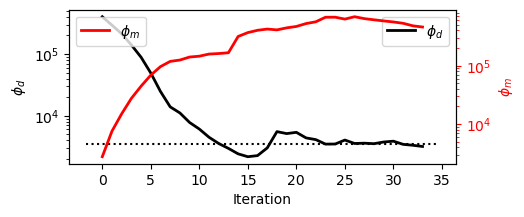

In [15]:
# Plot the data misfit and and model norm evolution across iterations
# Uses SimPEG plotting utilities (basic plotting)
save_out.plot_misfit_curves(dpi=300)

The plot shows the evolution of **data misfit** ($\phi_d$, black) and **model norm** ($\phi_m$, red).

- **Iterations 0-12 (L2 phase):**  
  $\phi_d$ drops quickly to the target by ~iter 12.  
  $\phi_m$ **slowly increases**, reflecting the gradual relaxation of $\beta$ and the model taking on a bit more structure even under smooth L2 regularization.

- **Iterations 12-end (IRLS phase):**  
  With the target met, IRLS promotes sparsity and sharper contrasts.  
  $\phi_m$ does a little jump from here and rises as the model becomes compact/blocky, while $\phi_d$ hovers near the target with mild oscillations from the reweighting.

**Takeaway:**  
The inversion first achieves an adequate data fit, then trades some model simplicity for sharper, geologically meaningful features, without materially sacrificing the misfit target.

### Data fit

Validating the data fit is a critical step before starting any interpratation. Without a good data fit, nothing conclusive can be said about the 3D density model. We want to make sure that most of the signal is captured, leaving only behind random noise (residuals).

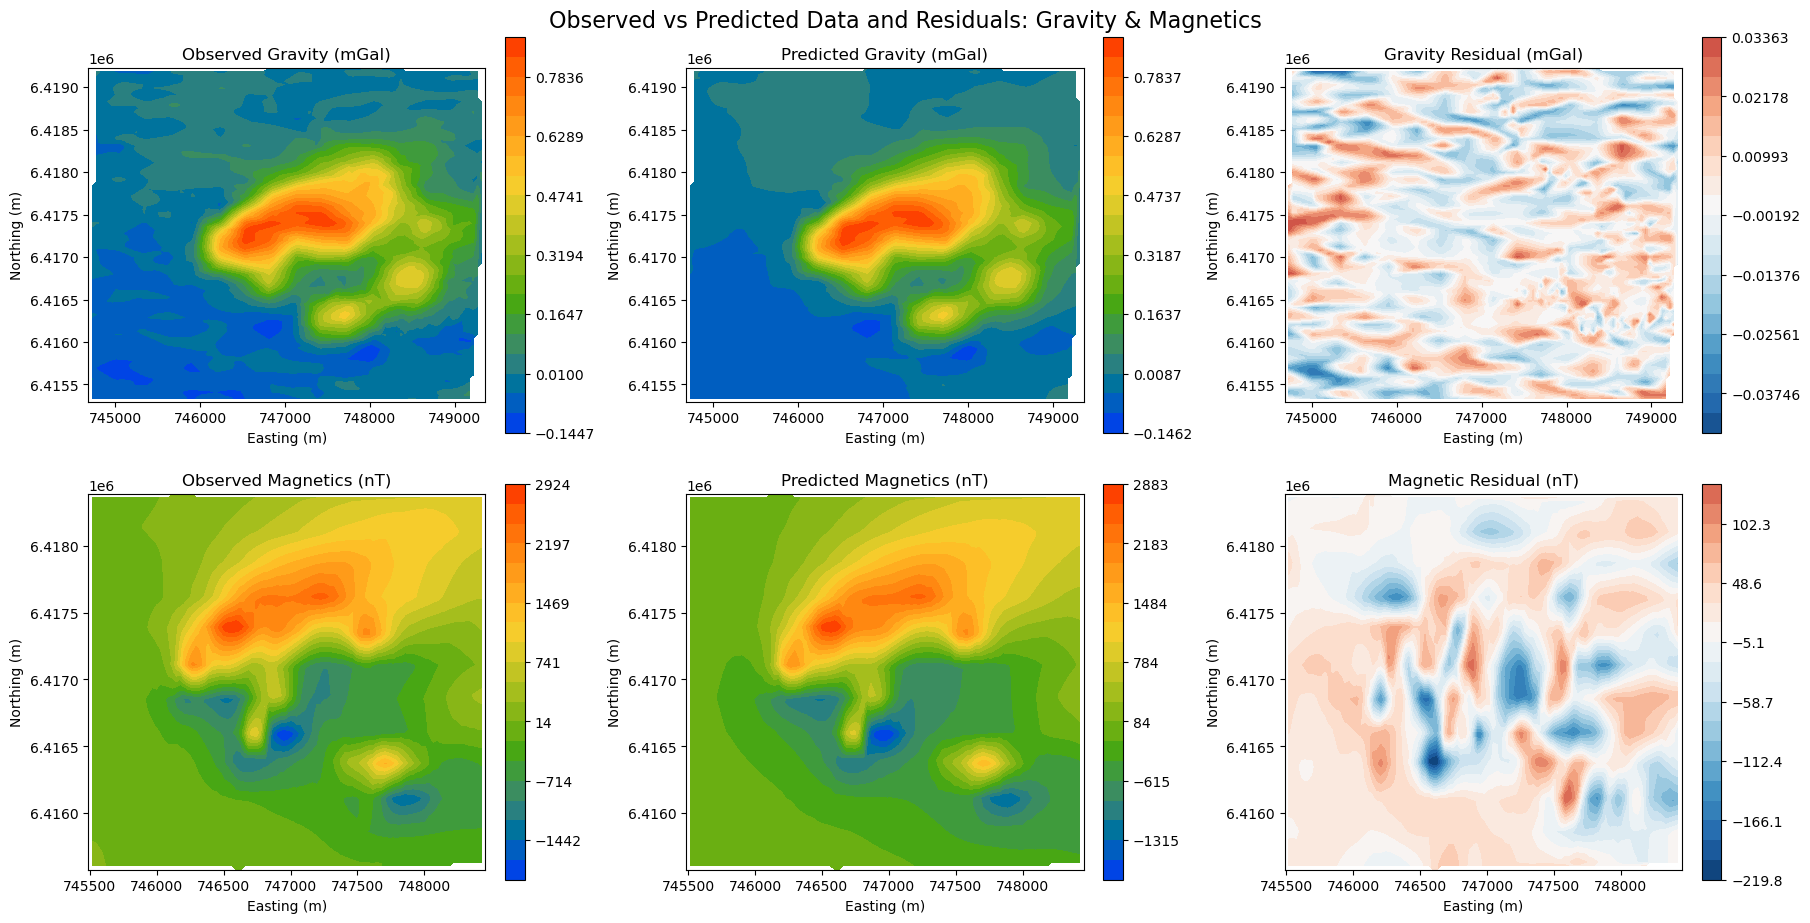

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(18, 9), constrained_layout=True)

# Gravity
grav_obs = grav_array[:, -1]
grav_pred = -inv_problem.dpred[0]  # Reverse sign for right-hand convention
grav_resid = grav_obs - grav_pred
grav_data = [grav_obs, grav_pred, grav_resid]
grav_titles = [
    "Observed Gravity (mGal)",
    "Predicted Gravity (mGal)",
    "Gravity Residual (mGal)",
]

for ax, title, data in zip(axes[0], grav_titles, grav_data, strict=False):
    if "Residual" in title:
        vlim = np.nanmax(np.abs(data))
        norm = mcolors.TwoSlopeNorm(vmin=-vlim, vcenter=0, vmax=vlim)
        contourOpts = {"cmap": "RdBu_r", "norm": norm}
    else:
        contourOpts = {"cmap": cc.m_CET_R2}
    im = plot2Ddata(
        grav_array[:, :2], data, ax=ax, ncontour=20, contourOpts=contourOpts
    )
    ax.set_title(title)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    plt.colorbar(im[0], ax=ax, orientation="vertical")

# Magnetics
mag_obs = mag_array[:, -1]
mag_pred = inv_problem.dpred[1]
mag_resid = mag_obs - mag_pred
mag_data = [mag_obs, mag_pred, mag_resid]
mag_titles = [
    "Observed Magnetics (nT)",
    "Predicted Magnetics (nT)",
    "Magnetic Residual (nT)",
]

for ax, title, data in zip(axes[1], mag_titles, mag_data, strict=False):
    if "Residual" in title:
        vlim = np.nanmax(np.abs(data))
        norm = mcolors.TwoSlopeNorm(vmin=-vlim, vcenter=0, vmax=vlim)
        contourOpts = {"cmap": "RdBu_r", "norm": norm}
    else:
        contourOpts = {"cmap": cc.m_CET_R2}
    im = plot2Ddata(mag_array[:, :2], data, ax=ax, ncontour=20, contourOpts=contourOpts)
    ax.set_title(title)
    ax.set_xlabel("Easting (m)")
    ax.set_ylabel("Northing (m)")
    plt.colorbar(im[0], ax=ax, orientation="vertical")

plt.suptitle(
    "Observed vs Predicted Data and Residuals: Gravity & Magnetics", fontsize=16, y=1.02
)
plt.show()

#### Profile Plot

It is always useful to plot the results along a selected profile to visualize the observed and predicted data and data uncertainties. It helps with assessing the quality of the fit, potential overfit or underfit.

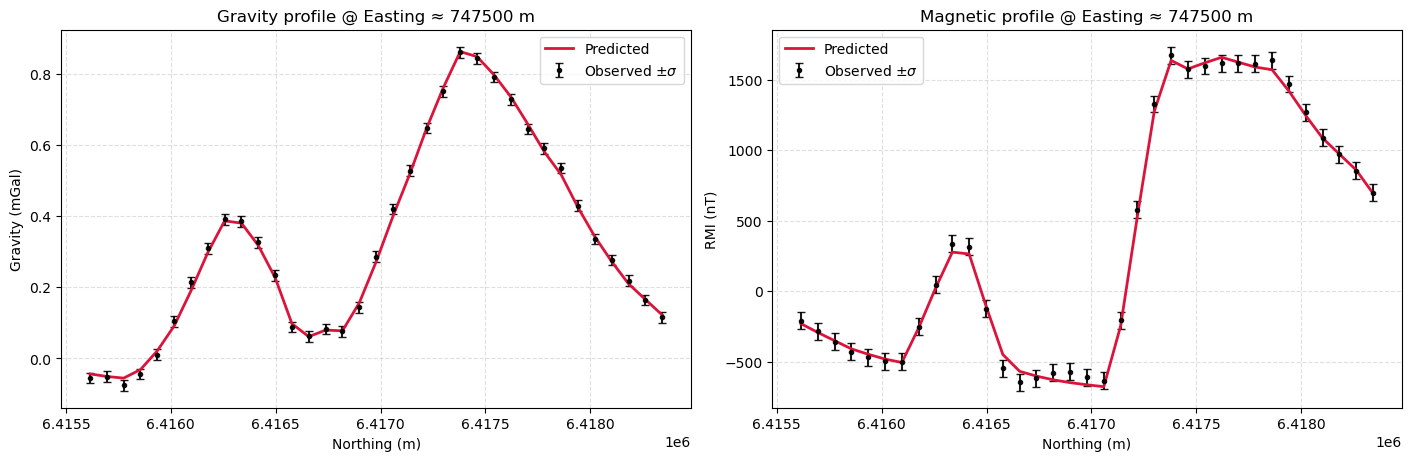

In [19]:
# 1) Pick a shared profile (N-S at fixed Easting). Switch to E-W by swapping axis logic.
E_fixed = 747500.0
n_samples = 50

# Build the line over the *overlap* of both surveys
g_xy, g_obs = grav_array[:, :2], grav_array[:, -1]
m_xy, m_obs = mag_array[:, :2], mag_array[:, -1]
all_xy = np.vstack([g_xy, m_xy])

ymin, ymax = all_xy[:, 1].min(), all_xy[:, 1].max()
y_line = np.linspace(ymin, ymax, n_samples)
line_xy = np.c_[np.full_like(y_line, E_fixed), y_line]  # (x=const, y varies)

# 2) Interpolate observed/predicted/uncertainties onto the SAME line points
g_pre = -inv_problem.dpred[0]  # flip if your gravity dpred uses opposite convention
m_pre = inv_problem.dpred[1]

g_err = (
    grav_uncertainties
    if np.ndim(grav_uncertainties)
    else np.full_like(g_obs, grav_uncertainties)
)
m_err = (
    mag_uncertainties
    if np.ndim(mag_uncertainties)
    else np.full_like(m_obs, mag_uncertainties)
)

g_obs_l = griddata(g_xy, g_obs, line_xy, method="linear")
g_pre_l = griddata(g_xy, g_pre, line_xy, method="linear")
g_err_l = griddata(g_xy, g_err, line_xy, method="linear")

m_obs_l = griddata(m_xy, m_obs, line_xy, method="linear")
m_pre_l = griddata(m_xy, m_pre, line_xy, method="linear")
m_err_l = griddata(m_xy, m_err, line_xy, method="linear")

# Keep only locations where both datasets interpolated successfully
mask = (
    (~np.isnan(g_obs_l))
    & (~np.isnan(g_pre_l))
    & (~np.isnan(m_obs_l))
    & (~np.isnan(m_pre_l))
)
yy = y_line[mask]
g_obs_l, g_pre_l, g_err_l = g_obs_l[mask], g_pre_l[mask], g_err_l[mask]
m_obs_l, m_pre_l, m_err_l = m_obs_l[mask], m_pre_l[mask], m_err_l[mask]

# 3) Plot (same coordinates/resolution; error bars = assigned std)
fig, ax = plt.subplots(1, 2, figsize=(14, 4.5), constrained_layout=True)

# Gravity
ax[0].errorbar(
    yy,
    g_obs_l,
    yerr=g_err_l,
    fmt="o",
    ms=3,
    capsize=3,
    color="k",
    alpha=0.9,
    label=r"Observed ±$\sigma$",
)
ax[0].plot(yy, g_pre_l, "-", lw=2, color="crimson", label="Predicted")
ax[0].set(
    title=f"Gravity profile @ Easting ≈ {E_fixed:.0f} m",
    xlabel="Northing (m)",
    ylabel="Gravity (mGal)",
)
ax[0].grid(True, ls="--", alpha=0.4)
ax[0].legend()

# Magnetics
ax[1].errorbar(
    yy,
    m_obs_l,
    yerr=m_err_l,
    fmt="o",
    ms=3,
    capsize=3,
    color="k",
    alpha=0.9,
    label=r"Observed ±$\sigma$",
)
ax[1].plot(yy, m_pre_l, "-", lw=2, color="crimson", label="Predicted")
ax[1].set(
    title=f"Magnetic profile @ Easting ≈ {E_fixed:.0f} m",
    xlabel="Northing (m)",
    ylabel="RMI (nT)",
)
ax[1].grid(True, ls="--", alpha=0.4)
ax[1].legend()

plt.show()

While there might still be some correlated signal in the residuals, overall the data fit is good. 
We can move on to interpretating the model.

### Models

The inversion took 13 iterations to reach the target misfit, followed by 12 iterations to increase sparsity. The figure below shows horizontal and vertical sections through both solutions. 

See the [Regularization Section](https://mirageoscience-simpeg-drivers.readthedocs-hosted.com/en/geopy-2297/inversion/regularization.html#regularization) for more details on sparsity constraints.

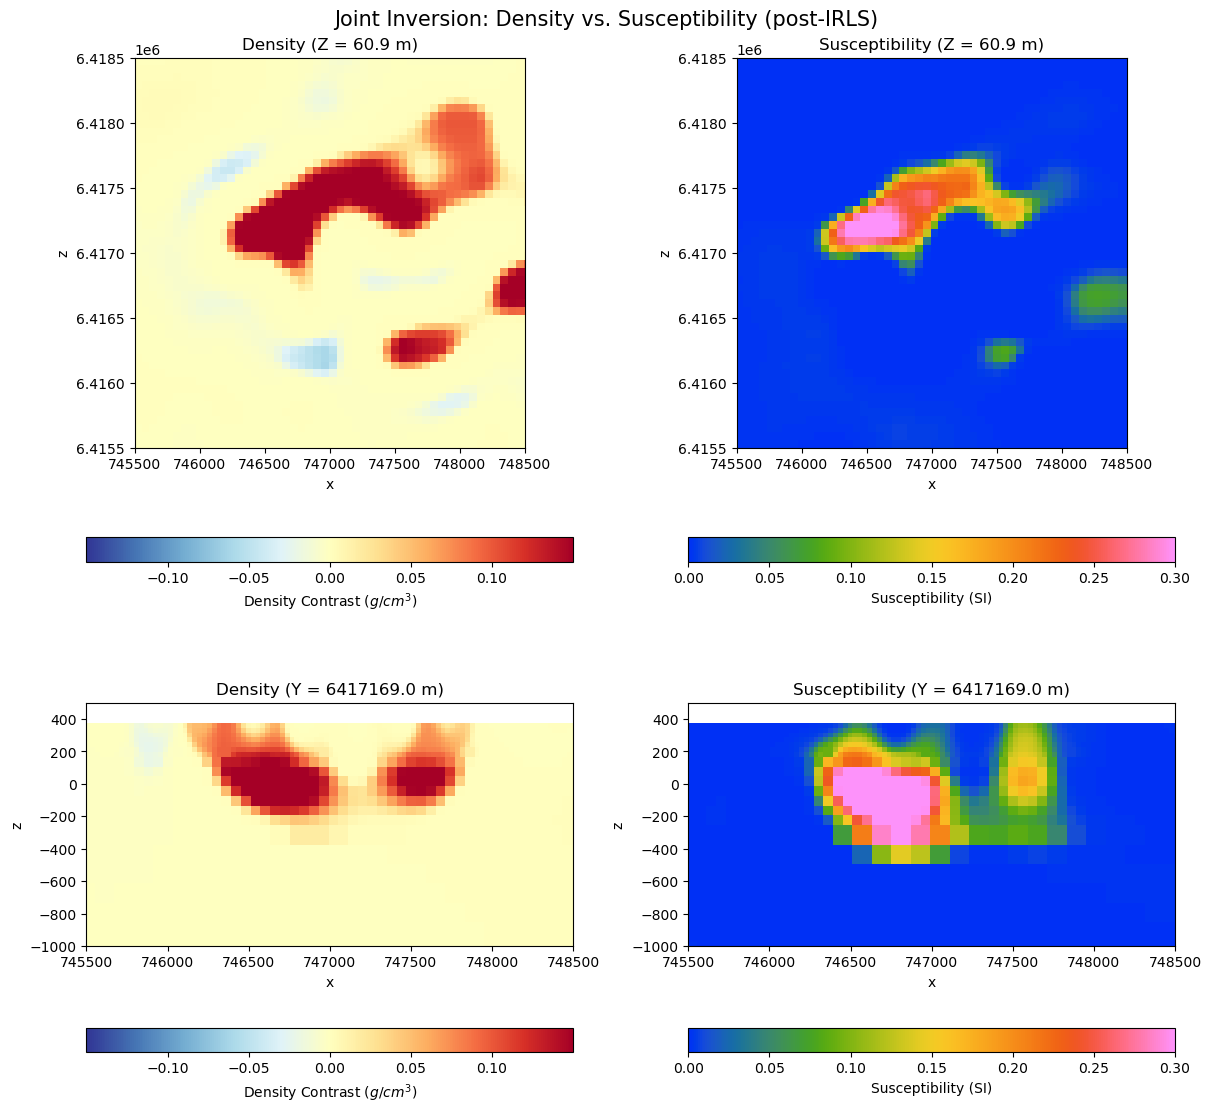

In [18]:
# # Mapping to ignore inactive cells when plotting
plotting_map = simpeg.maps.InjectActiveCells(octree, active, np.nan)

# Pull out joint-model parts (density / susceptibility) for plotting
dens_full = plotting_map * (proj_grav * rec_model)  # density contrast [g/cc]
chi_full = plotting_map * (proj_mag * rec_model)  # susceptibility [SI]

# Shared extents & slice indices
z_ind = 86
y_ind = 125
z_val = octree.cell_centers_z[z_ind]
y_val = octree.cell_centers_y[y_ind]

extent_xy = [745500, 748500]
extent_z = [-1000, 500]

dens_norm = mcolors.TwoSlopeNorm(
    vmin=-0.15, vcenter=0.0, vmax=0.15
)  # center at 0 for density
dens_cmap = mpl.cm.RdYlBu_r
sus_cmap = cc.m_CET_R1 if "cc" in globals() else mpl.cm.viridis  # CET-R2 if available

# Figure with taller top row (Z-slices)
fig, axes = plt.subplots(
    2,
    2,
    figsize=(12, 11),
    constrained_layout=True,
    gridspec_kw={"height_ratios": [1.2, 1]},
)

# What to plot: (array, label, normal, ind/None, axes idx, title)
to_plot = [
    (
        dens_full,
        "Density Contrast ($g/cm^3$)",
        "Z",
        z_ind,
        axes[0, 0],
        f"Density (Z = {z_val:.1f} m)",
    ),
    (
        dens_full,
        "Density Contrast ($g/cm^3$)",
        "Y",
        None,
        axes[1, 0],
        f"Density (Y = {y_val:.1f} m)",
    ),
    (
        chi_full,
        "Susceptibility (SI)",
        "Z",
        z_ind,
        axes[0, 1],
        f"Susceptibility (Z = {z_val:.1f} m)",
    ),
    (
        chi_full,
        "Susceptibility (SI)",
        "Y",
        None,
        axes[1, 1],
        f"Susceptibility (Y = {y_val:.1f} m)",
    ),
]

for arr, cbar_label, normal, ind, ax, title in to_plot:
    # Choose styling per property
    if "Density" in cbar_label:
        pcolor_opts = {"cmap": dens_cmap, "norm": dens_norm}
    else:
        pcolor_opts = {"cmap": sus_cmap, "vmax": 0.3}  # linear scale for susceptibility

    im = octree.plot_slice(arr, normal=normal, ind=ind, ax=ax, pcolor_opts=pcolor_opts)
    ax.set_title(title, fontsize=12)
    ax.set_xlim(extent_xy)
    ax.set_ylim([6415500, 6418500] if normal == "Z" else extent_z)
    ax.set_aspect("equal")
    plt.colorbar(im[0], ax=ax, orientation="horizontal", pad=0.10, label=cbar_label)

fig.suptitle("Joint Inversion: Density vs. Susceptibility (post-IRLS)", fontsize=15)
plt.show()

Readers can compare these results with the models obtained in the standalone [gravity](gravity-code) and [magnetics](magnetics-code) inversions.

We note the following:

- **Structural alignment:** Compared to the standalone inversions, we recover similar edges in the density and magnetic susceptibility. For instance, in the magnetics-only result the target looked more tabular/steeply dipping; jointly it resolves as a more cirular (in profile view) body that is co-located across the different physical properties.

 - **Lateral Extent:** In plan view, the density anomaly extends farther NE than the susceptibility. In a real-case scenario (the gravity data is synthetic here), this could reflect a denser, weakly magnetic continuation, limiting the magnetic footprint. 